In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.utils import shuffle

import torch.optim as optim

from MLTools import DEVICE, BATCH_SIZE, EPOCHS, N_FOLD
from MLTools import DataManager
from MLTools import SimpleDNN, SelfNormDNN
from MLTools import EarlyStopping
from MLTools import train, evaluate, predict

In [3]:
# global variables
MASS_POINT = "MHc130_MA90"
SIGNAL = f"TTToHcToWA_AToMuMu_{MASS_POINT}"
CHANNEL = "1E2Mu"

In [4]:
def split_sample(sample, n_split=4, shuf=True):
    """Divide sample and return as a list of subsamples"""
    if shuf:
        sample = shuffle(sample)
    sub_samples = list()
    fold = len(sample) // n_split
    for idx in range(n_split):
        if idx != n_split-1:
            sub_sample = sample.iloc[fold*idx: fold*(idx+1)]
        else:
            sub_sample = sample.iloc[fold*idx:]
        sub_samples.append(sub_sample)
        
    return sub_samples

In [5]:
# load dataset
signal = pd.read_csv(f"Outputs/{CHANNEL}/CSV/{SIGNAL}.csv", index_col=0)
fake = pd.read_csv(f"Outputs/{CHANNEL}/CSV/fake.csv", index_col=0)
ttX = pd.read_csv(f"Outputs/{CHANNEL}/CSV/ttX.csv", index_col=0)
rare = pd.read_csv(f"Outputs/{CHANNEL}/CSV/rare.csv", index_col=0)
VV = pd.read_csv(f"Outputs/{CHANNEL}/CSV/VV.csv", index_col=0)
DY = pd.read_csv(f"Outputs/{CHANNEL}/CSV/DY.csv", index_col=0)
ZG = pd.read_csv(f"Outputs/{CHANNEL}/CSV/ZG.csv", index_col=0)

In [6]:
# will make 3 discriminators
# signal vs ttX, signal vs fake, signal vs others
others = pd.concat([rare, VV, DY, ZG])

signal_fold = split_sample(signal)
fake_fold = split_sample(fake)
ttX_fold = split_sample(ttX)
others_fold = split_sample(others)

In [7]:
features = [
    'mu1_px', 'mu1_py', 'mu1_pz', 'mu1_mass', 'mu1_charge', 'mu2_px', 'mu2_py',
    'mu2_pz', 'mu2_mass', 'mu2_charge', 'ele_px', 'ele_py', 'ele_pz',
    'ele_mass', 'j1_px', 'j1_py', 'j1_pz', 'j1_mass', 'j1_bscore', 'j2_px',
    'j2_py', 'j2_pz', 'j2_mass', 'j2_bscore', 'dR_mu1mu2', 'dR_mu1ele',
    'dR_mu2ele', 'dR_j1ele', 'dR_j2ele', 'dR_j1j2', 'HT', 'MT', 'LT', 'MET',
    'Nj', 'Nb', 'avg_dRjets', 'avg_bscore'
]

In [8]:
manager = DataManager(signal_fold, fake_fold, features)
for idx in range(4):
    print(f"{idx} fold")
    train_loader, val_loader, test_loader = manager.get_dataloaders(idx=3)
    class_weights = manager.class_weights
    model = SelfNormDNN(len(features), 2, batch_norm=True).to(DEVICE)
    #model = SimpleDNN(len(features), 2, activation='elu').to(DEVICE)
    optimizer = optim.Adadelta(model.parameters(), lr=0.008)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    early_stopping = EarlyStopping(patience=7, path=f"Outputs/{CHANNEL}/{MASS_POINT}/chkpoint_sig_vs_fake_{idx}.pt")
	
    for epoch in range(EPOCHS):
        loss, acc = train(model, train_loader, optimizer, class_weights, epoch)
        scheduler.step()
        test_loss, test_acc = evaluate(model, val_loader, class_weights, epoch)
        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    X_train, X_test = manager.X_train, manager.X_test
    y_train, y_test = manager.y_train, manager.y_test

    pred_test = predict(model, X_test)
    pred_prob_train = predict(model, X_train, prob=True)
    pred_prob_test = predict(model, X_test, prob=True)
    cm = metrics.confusion_matrix(y_test, pred_test)
    fpr_train, tpr_train, thresh_train = metrics.roc_curve(y_train,
	                                                       pred_prob_train,
	                                                       pos_label=0)
    fpr, tpr, thresh = metrics.roc_curve(y_test, pred_prob_test, pos_label=0)
    auc_train = metrics.auc(fpr_train, tpr_train)
    auc = metrics.auc(fpr, tpr)
    print(auc_train, auc)
    print((auc_train-auc)/auc_train)

    plt.figure(figsize=(14, 6))
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title("Confusion Matrix")
    ax1 = sns.heatmap(cm, annot=True,
	                      fmt='d',
	                      square=False,
	                      xticklabels=['signal', 'background'],
	                      yticklabels=['signal', 'background'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title(f'ROC curve\nAUC:{round(auc, 3)}')
    ax2.plot(tpr_train, 1 - fpr_train, 'r--', label='train roc')
    ax2.plot(tpr, 1 - fpr, 'b--', label='test roc')
    ax2.legend(loc='best')
    ax2.set_xlabel('signal efficiency')
    ax2.set_ylabel('background rejection')

    plt.savefig(f"Outputs/{CHANNEL}/{MASS_POINT}/roc_sig_vs_fake_{idx}.png")

0 fold
Assume N_FOLD = 4
[0] Train Loss: 0.7239083647727966, Train Acc: 56.87145557655955
[0] Test Loss: 1.3523724414837697, Test Acc: 58.7034587034587

[1] Train Loss: 0.7002586126327515, Train Acc: 61.62570888468809
[1] Test Loss: 1.312747439822635, Test Acc: 62.1054621054621



KeyboardInterrupt: 

0 fold
Assume N_FOLD = 4
[0] Train Loss: 0.6020584106445312, Train Acc: 56.29310659416852
[0] Test Loss: 1.1629874380187142, Test Acc: 58.85637133265217

[1] Train Loss: 0.5866085886955261, Train Acc: 59.00357625077546
[1] Test Loss: 1.1535768543711684, Test Acc: 59.99124215443001

[2] Train Loss: 0.5824369192123413, Train Acc: 60.64755683684268
[2] Test Loss: 1.146816021472829, Test Acc: 61.72091665450299

[3] Train Loss: 0.5790205001831055, Train Acc: 62.30978360033573
[3] Test Loss: 1.1414322235726593, Test Acc: 63.596555247409135

[4] Train Loss: 0.5755752921104431, Train Acc: 63.91818414042258
[4] Test Loss: 1.135224181567643, Test Acc: 64.73507517150782

[5] Train Loss: 0.5728591680526733, Train Acc: 65.3924752764296
[5] Test Loss: 1.1296217916586366, Test Acc: 65.39556269157787

[6] Train Loss: 0.5701519250869751, Train Acc: 66.44436740502864
[6] Test Loss: 1.1288737056377491, Test Acc: 67.40256896803386

[7] Train Loss: 0.5679354071617126, Train Acc: 67.55555961026165
[7] Test 

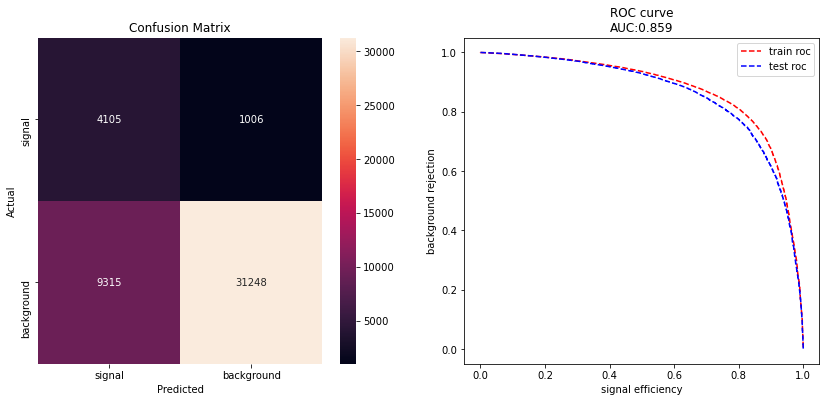

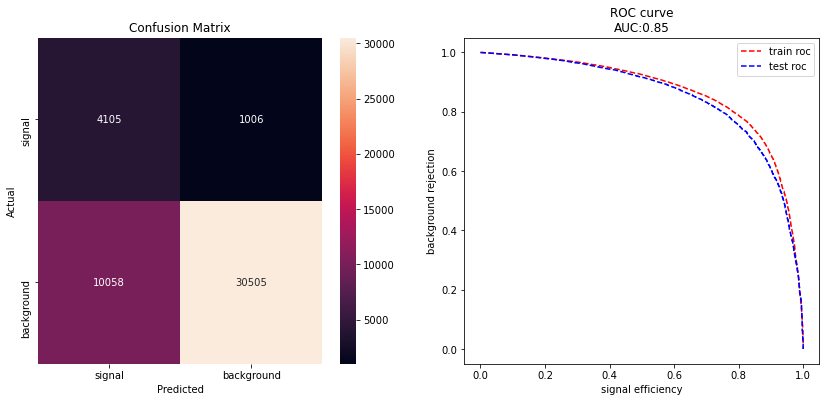

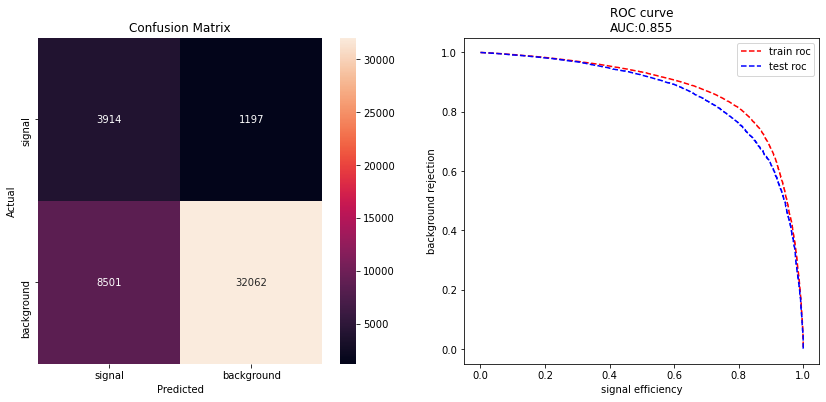

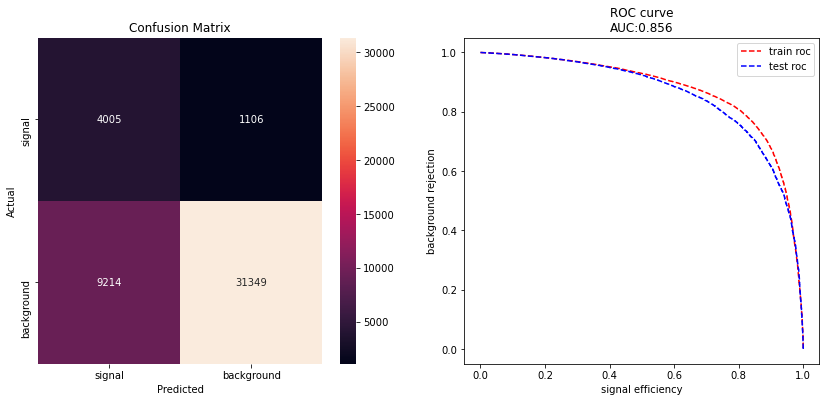

In [11]:
manager = DataManager(signal_fold, ttX_fold, features)
for idx in range(4):
    print(f"{idx} fold")
    train_loader, val_loader, test_loader = manager.get_dataloaders(idx=3)
    class_weights = manager.class_weights
    model = SelfNormDNN(len(features), 2, batch_norm=True).to(DEVICE)
    #model = SimpleDNN(len(features), 2, activation='elu').to(DEVICE)
    optimizer = optim.Adadelta(model.parameters(), lr=0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    early_stopping = EarlyStopping(patience=7, path=f"Outputs/{CHANNEL}/{MASS_POINT}/chkpoint_sig_vs_ttX_{idx}.pt")
	
    for epoch in range(EPOCHS):
        loss, acc = train(model, train_loader, optimizer, class_weights, epoch)
        scheduler.step()
        test_loss, test_acc = evaluate(model, val_loader, class_weights, epoch)
        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    X_train, X_test = manager.X_train, manager.X_test
    y_train, y_test = manager.y_train, manager.y_test

    pred_test = predict(model, X_test)
    pred_prob_train = predict(model, X_train, prob=True)
    pred_prob_test = predict(model, X_test, prob=True)
    cm = metrics.confusion_matrix(y_test, pred_test)
    fpr_train, tpr_train, thresh_train = metrics.roc_curve(y_train,
	                                                       pred_prob_train,
	                                                       pos_label=0)
    fpr, tpr, thresh = metrics.roc_curve(y_test, pred_prob_test, pos_label=0)
    auc_train = metrics.auc(fpr_train, tpr_train)
    auc = metrics.auc(fpr, tpr)
    print(auc_train, auc)
    print((auc_train-auc)/auc_train)

    plt.figure(figsize=(14, 6))
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title("Confusion Matrix")
    ax1 = sns.heatmap(cm, annot=True,
	                      fmt='d',
	                      square=False,
	                      xticklabels=['signal', 'background'],
	                      yticklabels=['signal', 'background'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title(f'ROC curve\nAUC:{round(auc, 3)}')
    ax2.plot(tpr_train, 1 - fpr_train, 'r--', label='train roc')
    ax2.plot(tpr, 1 - fpr, 'b--', label='test roc')
    ax2.legend(loc='best')
    ax2.set_xlabel('signal efficiency')
    ax2.set_ylabel('background rejection')

    plt.savefig(f"Outputs/{CHANNEL}/{MASS_POINT}/roc_sig_vs_ttX_{idx}.png")

0 fold
Assume N_FOLD = 4
[0] Train Loss: 0.5618451833724976, Train Acc: 74.48223707955933
[0] Test Loss: 0.959237307314202, Test Acc: 81.08070947339475

[1] Train Loss: 0.46149590611457825, Train Acc: 84.58656308543733
[1] Test Loss: 0.871915943403282, Test Acc: 86.21614189467896

[2] Train Loss: 0.43114134669303894, Train Acc: 87.6475946582335
[2] Test Loss: 0.831418168933228, Test Acc: 88.44355836656125

[3] Train Loss: 0.41562432050704956, Train Acc: 89.1463142154925
[3] Test Loss: 0.8084645884312053, Test Acc: 89.24102846143269

[4] Train Loss: 0.4061976373195648, Train Acc: 89.96957874293179
[4] Test Loss: 0.7940374820477923, Test Acc: 89.91475319675513

[5] Train Loss: 0.3997221291065216, Train Acc: 90.5401921523469
[5] Test Loss: 0.7845681456806209, Test Acc: 90.17599340024749

[6] Train Loss: 0.39642834663391113, Train Acc: 90.82721757214307
[6] Test Loss: 0.7791427125567569, Test Acc: 90.18286814244466

[7] Train Loss: 0.3935694396495819, Train Acc: 90.86331058900366
[7] Test 

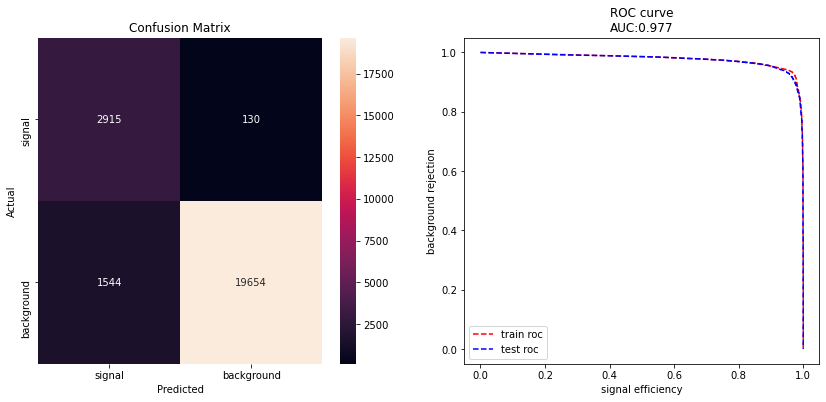

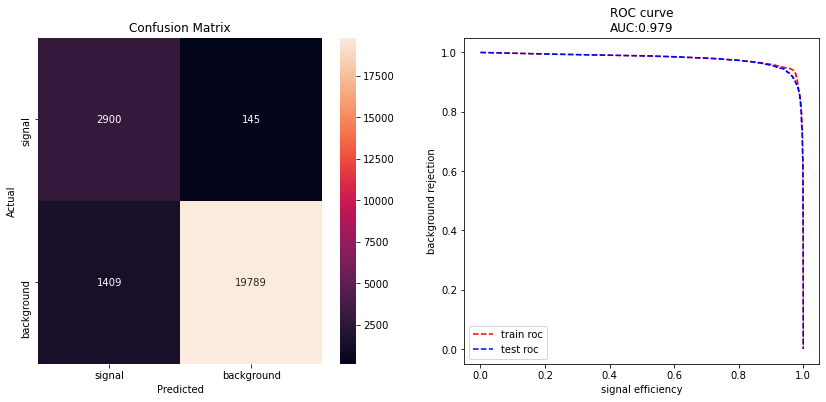

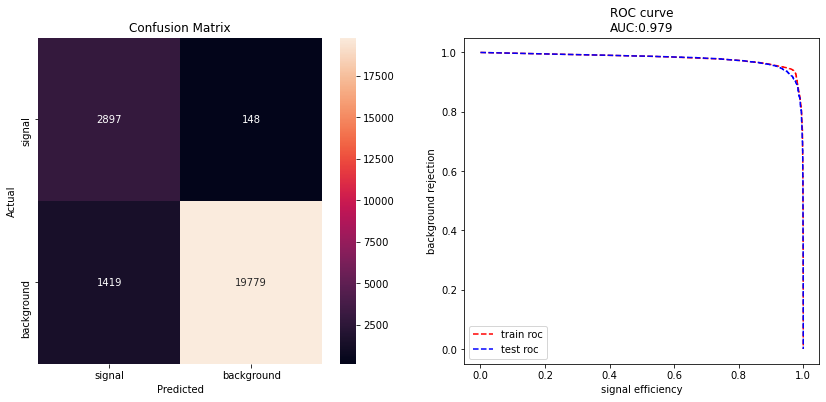

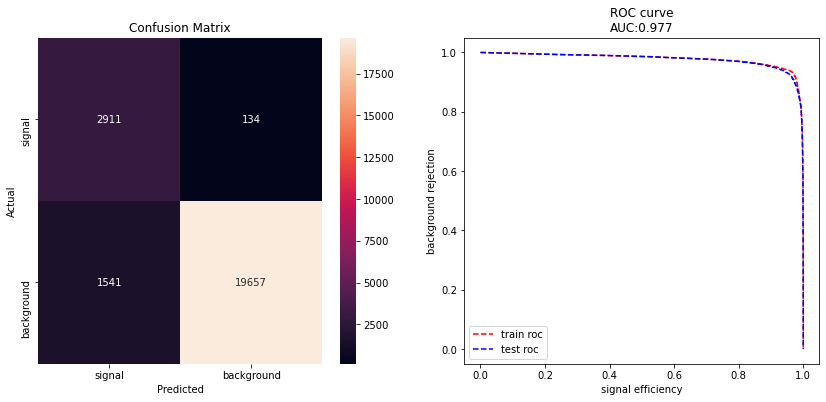

In [9]:
manager = DataManager(signal_fold, others_fold, features)
for idx in range(4):
    print(f"{idx} fold")
    train_loader, val_loader, test_loader = manager.get_dataloaders(idx=3)
    class_weights = manager.class_weights
    model = SelfNormDNN(len(features), 2).to(DEVICE)
    #model = SimpleDNN(len(features), 2, activation='elu').to(DEVICE)
    optimizer = optim.Adadelta(model.parameters(), lr=0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    early_stopping = EarlyStopping(patience=7, path=f"Outputs/{CHANNEL}/{MASS_POINT}/chkpoint_sig_vs_others_{idx}.pt")
	
    for epoch in range(EPOCHS):
        loss, acc = train(model, train_loader, optimizer, class_weights, epoch)
        scheduler.step()
        test_loss, test_acc = evaluate(model, val_loader, class_weights, epoch)
        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    X_train, X_test = manager.X_train, manager.X_test
    y_train, y_test = manager.y_train, manager.y_test

    pred_test = predict(model, X_test)
    pred_prob_train = predict(model, X_train, prob=True)
    pred_prob_test = predict(model, X_test, prob=True)
    cm = metrics.confusion_matrix(y_test, pred_test)
    fpr_train, tpr_train, thresh_train = metrics.roc_curve(y_train,
	                                                       pred_prob_train,
	                                                       pos_label=0)
    fpr, tpr, thresh = metrics.roc_curve(y_test, pred_prob_test, pos_label=0)
    auc_train = metrics.auc(fpr_train, tpr_train)
    auc = metrics.auc(fpr, tpr)
    print(auc_train, auc)
    print((auc_train-auc)/auc_train)

    plt.figure(figsize=(14, 6))
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title("Confusion Matrix")
    ax1 = sns.heatmap(cm, annot=True,
	                      fmt='d',
	                      square=False,
	                      xticklabels=['signal', 'background'],
	                      yticklabels=['signal', 'background'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title(f'ROC curve\nAUC:{round(auc, 3)}')
    ax2.plot(tpr_train, 1 - fpr_train, 'r--', label='train roc')
    ax2.plot(tpr, 1 - fpr, 'b--', label='test roc')
    ax2.legend(loc='best')
    ax2.set_xlabel('signal efficiency')
    ax2.set_ylabel('background rejection')

    plt.savefig(f"Outputs/{CHANNEL}/{MASS_POINT}/roc_sig_vs_others_{idx}.png")

0 fold
Assume N_FOLD = 4
[0] Train Loss: 0.7520676255226135, Train Acc: 51.09245772126898
[0] Test Loss: 1.477473010136386, Test Acc: 50.95038262157492

[1] Train Loss: 0.7367395162582397, Train Acc: 52.57992840390075
[1] Test Loss: 1.4146320208359047, Test Acc: 54.7519131078746

[2] Train Loss: 0.7206690311431885, Train Acc: 55.017899024811754
[2] Test Loss: 1.3881599691819921, Test Acc: 56.40582572204394

[3] Train Loss: 0.7011111378669739, Train Acc: 57.36946056042464
[3] Test Loss: 1.3516199944843865, Test Acc: 59.46679832140212

[4] Train Loss: 0.6877928972244263, Train Acc: 59.14084680903592
[4] Test Loss: 1.3552420867339854, Test Acc: 59.39274253270797

EarlyStopping counter: 1 out of 7
[5] Train Loss: 0.6774024963378906, Train Acc: 60.38760646833724
[5] Test Loss: 1.2969463558380647, Test Acc: 62.947420390027155

[6] Train Loss: 0.6607420444488525, Train Acc: 62.43673620540674
[6] Test Loss: 1.3067972582965626, Test Acc: 63.24364354480375

EarlyStopping counter: 1 out of 7
[7] 

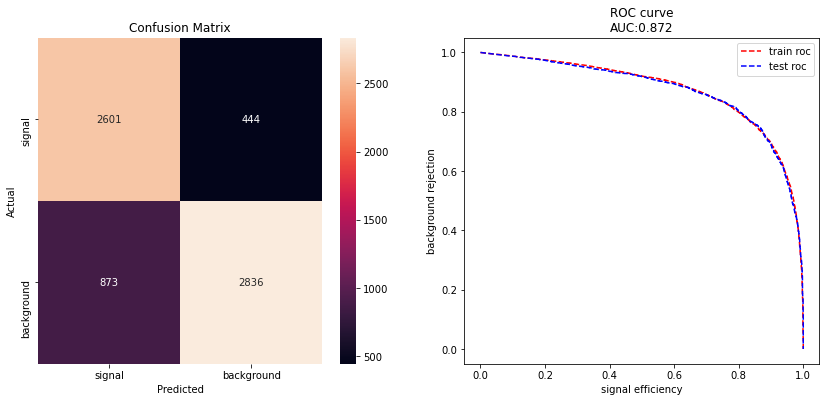

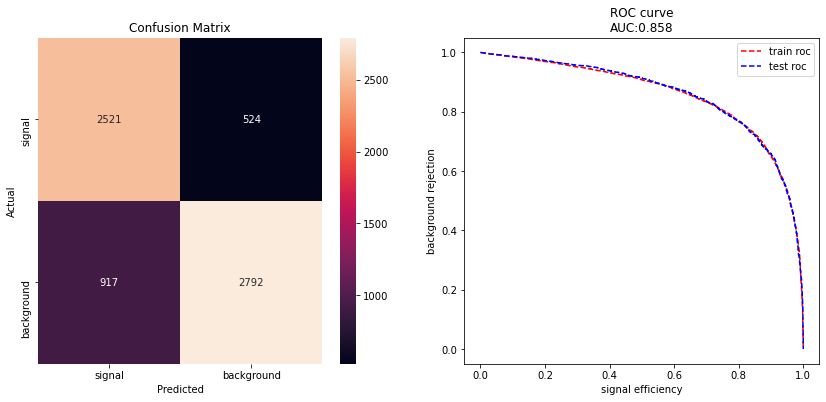

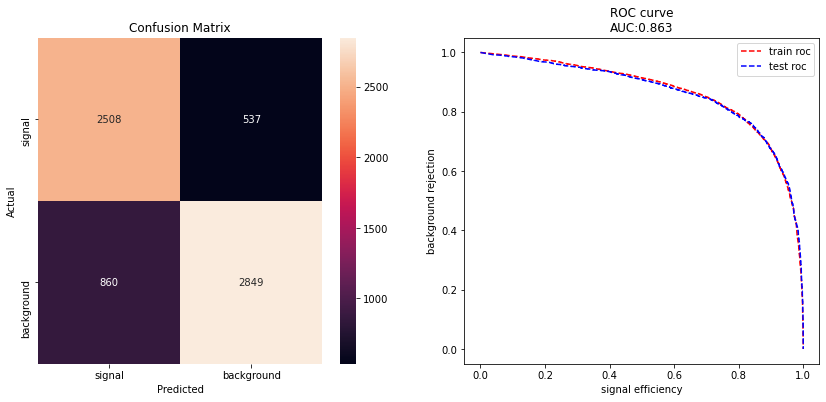

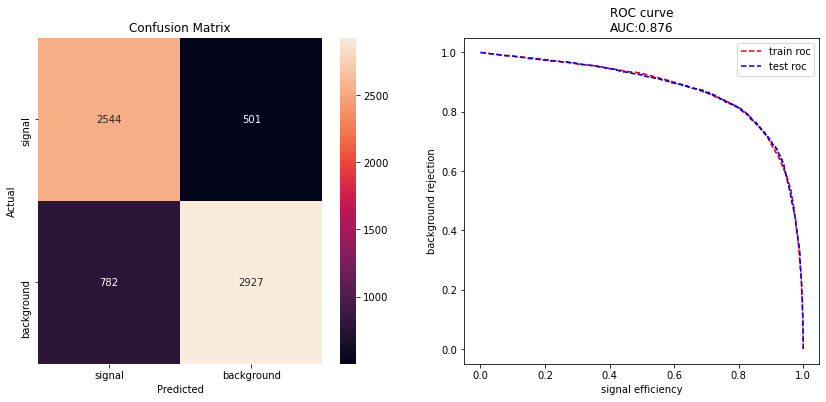

In [10]:
manager = DataManager(signal_fold, fake_fold, features)
for idx in range(4):
    print(f"{idx} fold")
    train_loader, val_loader, test_loader = manager.get_dataloaders(idx=3)
    class_weights = manager.class_weights
    #model = SelfNormDNN(len(features), 2).to(DEVICE)
    model = SimpleDNN(len(features), 2, activation='relu').to(DEVICE)
    optimizer = optim.Adadelta(model.parameters(), lr=0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    early_stopping = EarlyStopping(patience=7, path=f"Outputs/{CHANNEL}/{MASS_POINT}/chkpoint_simplednn_relu_sig_vs_fake_{idx}.pt")
	
    for epoch in range(EPOCHS):
        loss, acc = train(model, train_loader, optimizer, class_weights, epoch)
        scheduler.step()
        test_loss, test_acc = evaluate(model, val_loader, class_weights, epoch)
        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    X_train, X_test = manager.X_train, manager.X_test
    y_train, y_test = manager.y_train, manager.y_test

    pred_test = predict(model, X_test)
    pred_prob_train = predict(model, X_train, prob=True)
    pred_prob_test = predict(model, X_test, prob=True)
    cm = metrics.confusion_matrix(y_test, pred_test)
    fpr_train, tpr_train, thresh_train = metrics.roc_curve(y_train,
	                                                       pred_prob_train,
	                                                       pos_label=0)
    fpr, tpr, thresh = metrics.roc_curve(y_test, pred_prob_test, pos_label=0)
    auc_train = metrics.auc(fpr_train, tpr_train)
    auc = metrics.auc(fpr, tpr)
    print(auc_train, auc)
    print((auc_train-auc)/auc_train)

    plt.figure(figsize=(14, 6))
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title("Confusion Matrix")
    ax1 = sns.heatmap(cm, annot=True,
	                      fmt='d',
	                      square=False,
	                      xticklabels=['signal', 'background'],
	                      yticklabels=['signal', 'background'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title(f'ROC curve\nAUC:{round(auc, 3)}')
    ax2.plot(tpr_train, 1 - fpr_train, 'r--', label='train roc')
    ax2.plot(tpr, 1 - fpr, 'b--', label='test roc')
    ax2.legend(loc='best')
    ax2.set_xlabel('signal efficiency')
    ax2.set_ylabel('background rejection')

    plt.savefig(f"Outputs/{CHANNEL}/{MASS_POINT}/roc_simplednn_relu_sig_vs_fake_{idx}.png")

0 fold
Assume N_FOLD = 4
[0] Train Loss: 0.6994495391845703, Train Acc: 51.79639574215988
[0] Test Loss: 1.275986723206565, Test Acc: 53.61183305304999

[1] Train Loss: 0.6204314827919006, Train Acc: 57.30502417490015
[1] Test Loss: 1.1924568926261991, Test Acc: 58.607246598379454

[2] Train Loss: 0.5935768485069275, Train Acc: 61.35551436161064
[2] Test Loss: 1.141543592631753, Test Acc: 62.70830148295368

[3] Train Loss: 0.57463139295578, Train Acc: 64.34632216637682
[3] Test Loss: 1.1205597507025995, Test Acc: 65.41813178413086

[4] Train Loss: 0.5612806677818298, Train Acc: 66.42746574426205
[4] Test Loss: 1.1035236311403551, Test Acc: 66.91637364317383

[5] Train Loss: 0.5524158477783203, Train Acc: 68.11588663596231
[5] Test Loss: 1.081989982918741, Test Acc: 68.88854915150588

[6] Train Loss: 0.5442187786102295, Train Acc: 69.79570776081182
[6] Test Loss: 1.0758497771493631, Test Acc: 69.73322121999695

[7] Train Loss: 0.5390396118164062, Train Acc: 70.90316662526038
[7] Test Lo

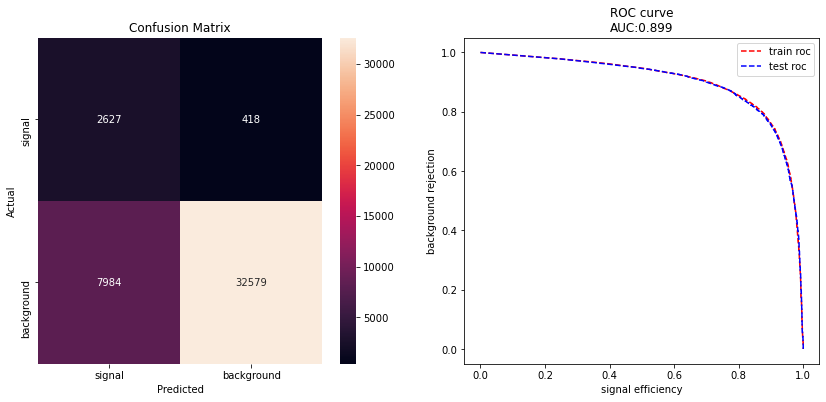

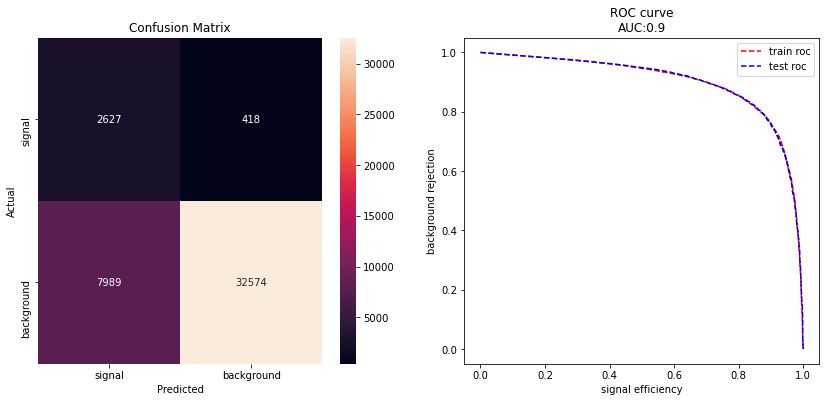

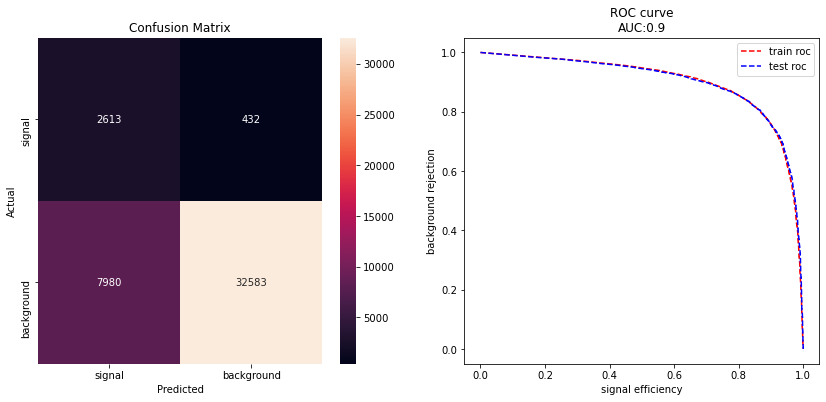

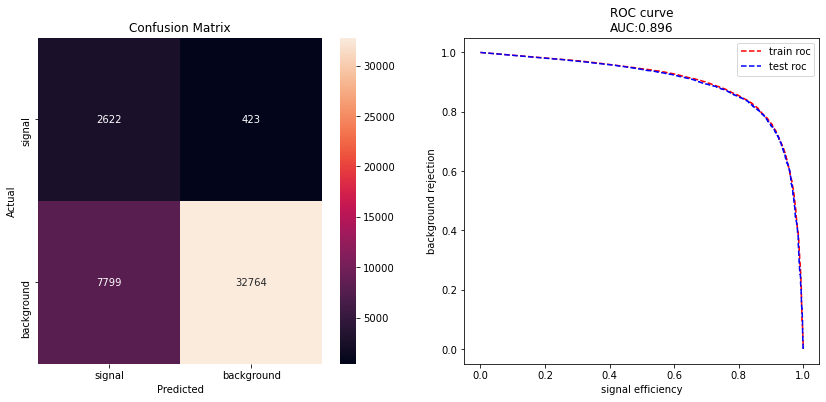

In [11]:
manager = DataManager(signal_fold, ttX_fold, features)
for idx in range(4):
    print(f"{idx} fold")
    train_loader, val_loader, test_loader = manager.get_dataloaders(idx=3)
    class_weights = manager.class_weights
    #model = SelfNormDNN(len(features), 2).to(DEVICE)
    model = SimpleDNN(len(features), 2, activation='relu').to(DEVICE)
    optimizer = optim.Adadelta(model.parameters(), lr=0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    early_stopping = EarlyStopping(patience=7, path=f"Outputs/{CHANNEL}/{MASS_POINT}/chkpoint_simplednn_relu_sig_vs_ttX_{idx}.pt")
	
    for epoch in range(EPOCHS):
        loss, acc = train(model, train_loader, optimizer, class_weights, epoch)
        scheduler.step()
        test_loss, test_acc = evaluate(model, val_loader, class_weights, epoch)
        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    X_train, X_test = manager.X_train, manager.X_test
    y_train, y_test = manager.y_train, manager.y_test

    pred_test = predict(model, X_test)
    pred_prob_train = predict(model, X_train, prob=True)
    pred_prob_test = predict(model, X_test, prob=True)
    cm = metrics.confusion_matrix(y_test, pred_test)
    fpr_train, tpr_train, thresh_train = metrics.roc_curve(y_train,
	                                                       pred_prob_train,
	                                                       pos_label=0)
    fpr, tpr, thresh = metrics.roc_curve(y_test, pred_prob_test, pos_label=0)
    auc_train = metrics.auc(fpr_train, tpr_train)
    auc = metrics.auc(fpr, tpr)
    print(auc_train, auc)
    print((auc_train-auc)/auc_train)

    plt.figure(figsize=(14, 6))
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title("Confusion Matrix")
    ax1 = sns.heatmap(cm, annot=True,
	                      fmt='d',
	                      square=False,
	                      xticklabels=['signal', 'background'],
	                      yticklabels=['signal', 'background'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title(f'ROC curve\nAUC:{round(auc, 3)}')
    ax2.plot(tpr_train, 1 - fpr_train, 'r--', label='train roc')
    ax2.plot(tpr, 1 - fpr, 'b--', label='test roc')
    ax2.legend(loc='best')
    ax2.set_xlabel('signal efficiency')
    ax2.set_ylabel('background rejection')

    plt.savefig(f"Outputs/{CHANNEL}/{MASS_POINT}/roc_simplednn_relu_sig_vs_ttX_{idx}.png")

0 fold
Assume N_FOLD = 4
[0] Train Loss: 0.6591835021972656, Train Acc: 60.06049877111871
[0] Test Loss: 1.1433754203310698, Test Acc: 66.70562353911728

[1] Train Loss: 0.5573520660400391, Train Acc: 69.85545606104876
[1] Test Loss: 1.0420550426754323, Test Acc: 72.9410147119483

[2] Train Loss: 0.5284166932106018, Train Acc: 73.14335802554011
[2] Test Loss: 1.0042153081391711, Test Acc: 75.07905953526743

[3] Train Loss: 0.5106102228164673, Train Acc: 75.20237870168262
[3] Test Loss: 0.98351268749953, Test Acc: 76.02089921627939

[4] Train Loss: 0.49907568097114563, Train Acc: 76.66156781190382
[4] Test Loss: 0.9680843471284255, Test Acc: 77.24460332737522

[5] Train Loss: 0.488849401473999, Train Acc: 77.97638485468264
[5] Test Loss: 0.954475113307366, Test Acc: 78.20019249278153

[6] Train Loss: 0.4837290942668915, Train Acc: 78.83917982915972
[6] Test Loss: 0.9442645193178913, Test Acc: 79.63013886979239

[7] Train Loss: 0.47693634033203125, Train Acc: 79.6865063678394
[7] Test Lo

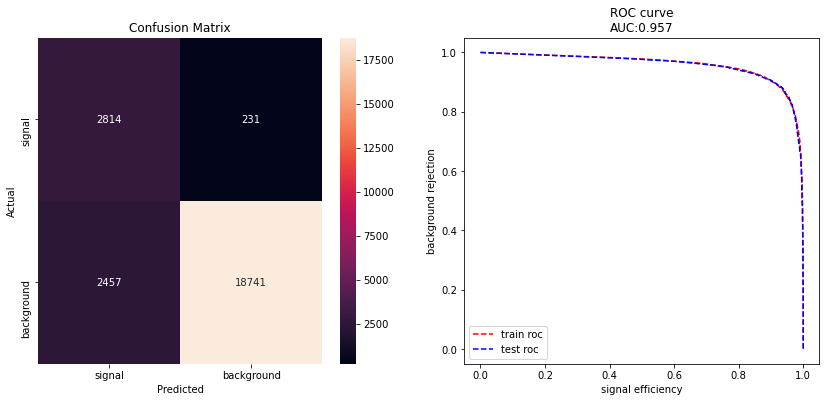

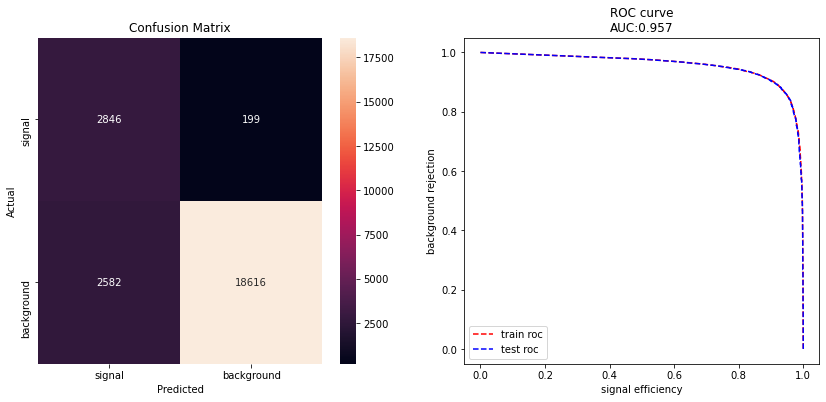

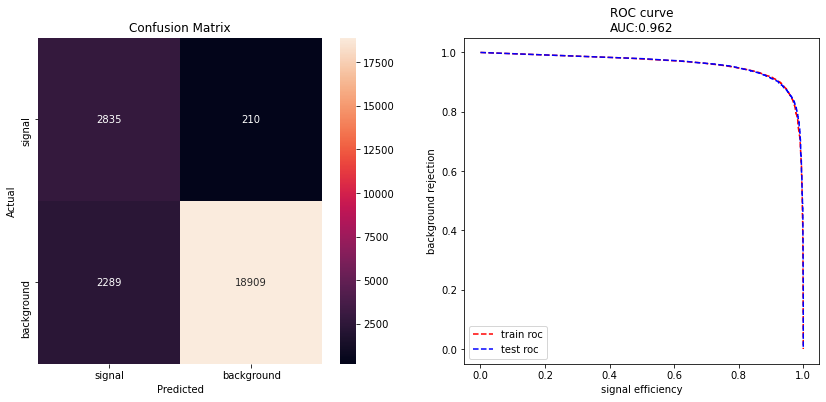

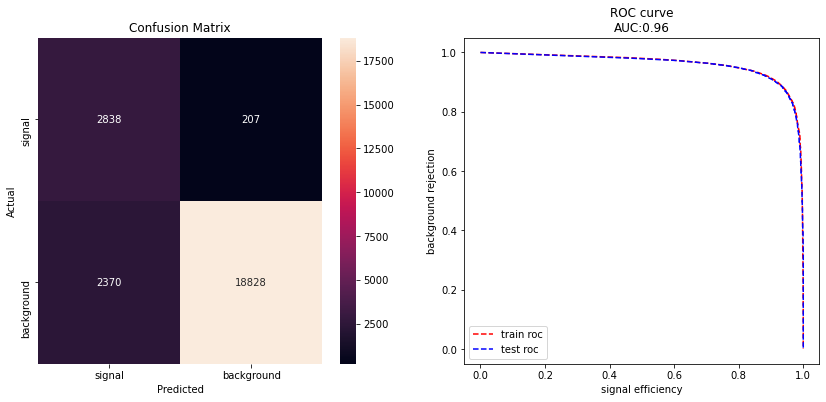

In [12]:
manager = DataManager(signal_fold, others_fold, features)
for idx in range(4):
    print(f"{idx} fold")
    train_loader, val_loader, test_loader = manager.get_dataloaders(idx=3)
    class_weights = manager.class_weights
    #model = SelfNormDNN(len(features), 2).to(DEVICE)
    model = SimpleDNN(len(features), 2, activation='relu').to(DEVICE)
    optimizer = optim.Adadelta(model.parameters(), lr=0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    early_stopping = EarlyStopping(patience=7, path=f"Outputs/{CHANNEL}/{MASS_POINT}/chkpoint_simplednn_relu_sig_vs_others_{idx}.pt")
	
    for epoch in range(EPOCHS):
        loss, acc = train(model, train_loader, optimizer, class_weights, epoch)
        scheduler.step()
        test_loss, test_acc = evaluate(model, val_loader, class_weights, epoch)
        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    X_train, X_test = manager.X_train, manager.X_test
    y_train, y_test = manager.y_train, manager.y_test

    pred_test = predict(model, X_test)
    pred_prob_train = predict(model, X_train, prob=True)
    pred_prob_test = predict(model, X_test, prob=True)
    cm = metrics.confusion_matrix(y_test, pred_test)
    fpr_train, tpr_train, thresh_train = metrics.roc_curve(y_train,
	                                                       pred_prob_train,
	                                                       pos_label=0)
    fpr, tpr, thresh = metrics.roc_curve(y_test, pred_prob_test, pos_label=0)
    auc_train = metrics.auc(fpr_train, tpr_train)
    auc = metrics.auc(fpr, tpr)
    print(auc_train, auc)
    print((auc_train-auc)/auc_train)

    plt.figure(figsize=(14, 6))
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title("Confusion Matrix")
    ax1 = sns.heatmap(cm, annot=True,
	                      fmt='d',
	                      square=False,
	                      xticklabels=['signal', 'background'],
	                      yticklabels=['signal', 'background'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title(f'ROC curve\nAUC:{round(auc, 3)}')
    ax2.plot(tpr_train, 1 - fpr_train, 'r--', label='train roc')
    ax2.plot(tpr, 1 - fpr, 'b--', label='test roc')
    ax2.legend(loc='best')
    ax2.set_xlabel('signal efficiency')
    ax2.set_ylabel('background rejection')

    plt.savefig(f"Outputs/{CHANNEL}/{MASS_POINT}/roc_simplednn_relu_sig_vs_others_{idx}.png")

0 fold
Assume N_FOLD = 4
[0] Train Loss: 0.7495200634002686, Train Acc: 51.25910381434391
[0] Test Loss: 1.4698865104680943, Test Acc: 54.011355220933105

[1] Train Loss: 0.7221665978431702, Train Acc: 54.73398345883224
[1] Test Loss: 1.4117164357566032, Test Acc: 56.60330782522834

[2] Train Loss: 0.7023002505302429, Train Acc: 57.06702876188125
[2] Test Loss: 1.3661148722923353, Test Acc: 59.04714885213527

[3] Train Loss: 0.6838301420211792, Train Acc: 59.227255894334036
[3] Test Loss: 1.339914804504289, Test Acc: 60.67637620340657

[4] Train Loss: 0.6657547950744629, Train Acc: 61.70843105789409
[4] Test Loss: 1.3101130748966305, Test Acc: 61.96000987410516

[5] Train Loss: 0.6545668244361877, Train Acc: 63.0662881125787
[5] Test Loss: 1.2523927107118613, Test Acc: 65.88496667489508

[6] Train Loss: 0.6415157914161682, Train Acc: 64.73892112084928
[6] Test Loss: 1.23486575218696, Test Acc: 67.16860034559367

[7] Train Loss: 0.634263277053833, Train Acc: 65.56597950870263
[7] Test L

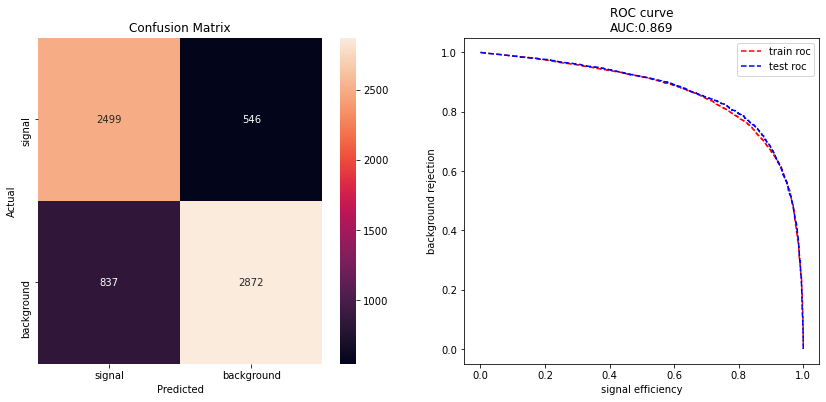

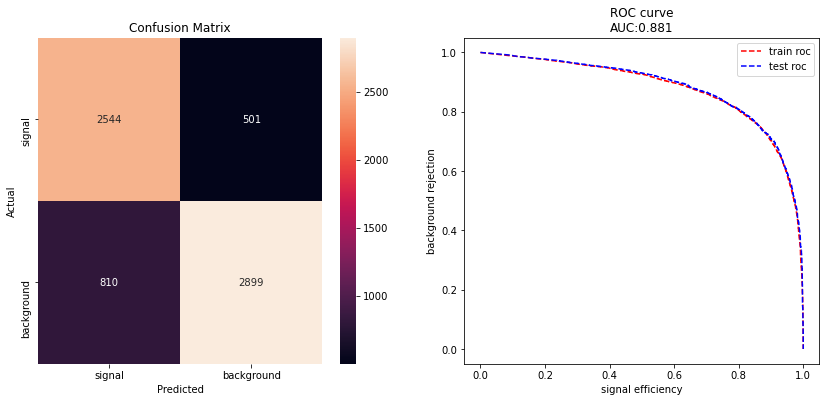

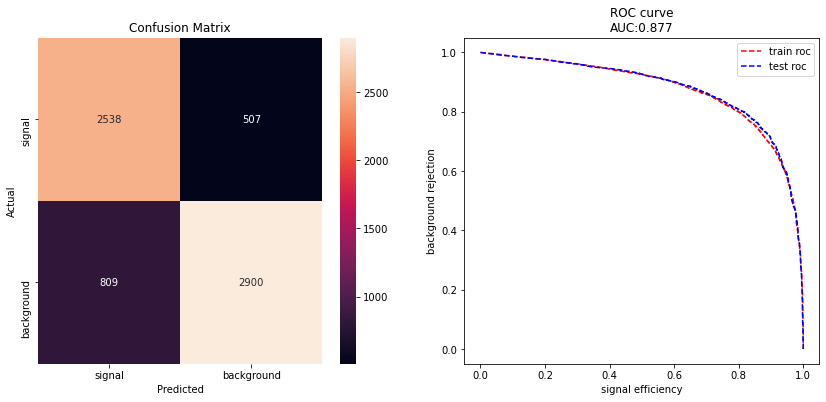

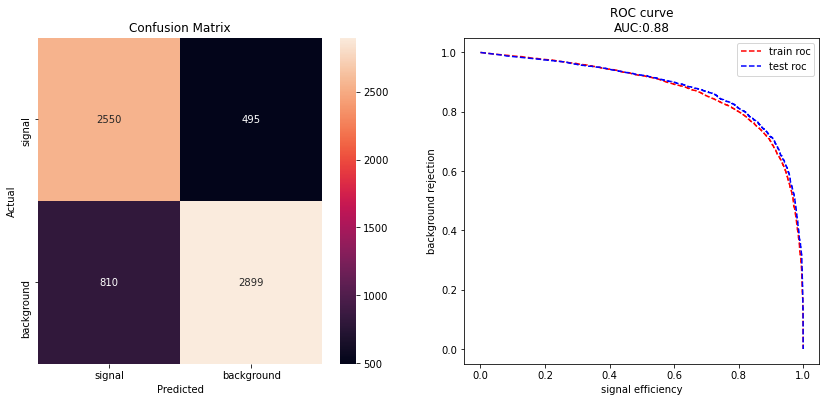

In [13]:
manager = DataManager(signal_fold, fake_fold, features)
for idx in range(4):
    print(f"{idx} fold")
    train_loader, val_loader, test_loader = manager.get_dataloaders(idx=3)
    class_weights = manager.class_weights
    #model = SelfNormDNN(len(features), 2).to(DEVICE)
    model = SimpleDNN(len(features), 2, activation='elu').to(DEVICE)
    optimizer = optim.Adadelta(model.parameters(), lr=0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    early_stopping = EarlyStopping(patience=7, path=f"Outputs/{CHANNEL}/{MASS_POINT}/chkpoint_simplednn_elu_sig_vs_fake_{idx}.pt")
	
    for epoch in range(EPOCHS):
        loss, acc = train(model, train_loader, optimizer, class_weights, epoch)
        scheduler.step()
        test_loss, test_acc = evaluate(model, val_loader, class_weights, epoch)
        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    X_train, X_test = manager.X_train, manager.X_test
    y_train, y_test = manager.y_train, manager.y_test

    pred_test = predict(model, X_test)
    pred_prob_train = predict(model, X_train, prob=True)
    pred_prob_test = predict(model, X_test, prob=True)
    cm = metrics.confusion_matrix(y_test, pred_test)
    fpr_train, tpr_train, thresh_train = metrics.roc_curve(y_train,
	                                                       pred_prob_train,
	                                                       pos_label=0)
    fpr, tpr, thresh = metrics.roc_curve(y_test, pred_prob_test, pos_label=0)
    auc_train = metrics.auc(fpr_train, tpr_train)
    auc = metrics.auc(fpr, tpr)
    print(auc_train, auc)
    print((auc_train-auc)/auc_train)

    plt.figure(figsize=(14, 6))
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title("Confusion Matrix")
    ax1 = sns.heatmap(cm, annot=True,
	                      fmt='d',
	                      square=False,
	                      xticklabels=['signal', 'background'],
	                      yticklabels=['signal', 'background'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title(f'ROC curve\nAUC:{round(auc, 3)}')
    ax2.plot(tpr_train, 1 - fpr_train, 'r--', label='train roc')
    ax2.plot(tpr, 1 - fpr, 'b--', label='test roc')
    ax2.legend(loc='best')
    ax2.set_xlabel('signal efficiency')
    ax2.set_ylabel('background rejection')

    plt.savefig(f"Outputs/{CHANNEL}/{MASS_POINT}/roc_simplednn_elu_sig_vs_fake_{idx}.png")

0 fold
Assume N_FOLD = 4
[0] Train Loss: 0.672274112701416, Train Acc: 53.01660710531848
[0] Test Loss: 1.2254541301158677, Test Acc: 55.729246292615805

[1] Train Loss: 0.6026788353919983, Train Acc: 57.93280715500602
[1] Test Loss: 1.1559292131781742, Test Acc: 60.12459868521633

[2] Train Loss: 0.5800328850746155, Train Acc: 61.34404800580962
[2] Test Loss: 1.1359502911622363, Test Acc: 61.93242623452072

[3] Train Loss: 0.5650742650032043, Train Acc: 63.950732891241614
[3] Test Loss: 1.1078199845281804, Test Acc: 64.85629108698976

[4] Train Loss: 0.5546718239784241, Train Acc: 66.00034399067403
[4] Test Loss: 1.0902397786781814, Test Acc: 66.12903225806451

[5] Train Loss: 0.5503339767456055, Train Acc: 67.23011065033349
[5] Test Loss: 1.0807850961199668, Test Acc: 67.25653569790552

[6] Train Loss: 0.5459561944007874, Train Acc: 68.31941445143043
[6] Test Loss: 1.0644736768929277, Test Acc: 68.72420119247822

[7] Train Loss: 0.5398597121238708, Train Acc: 69.57020276339175
[7] Te

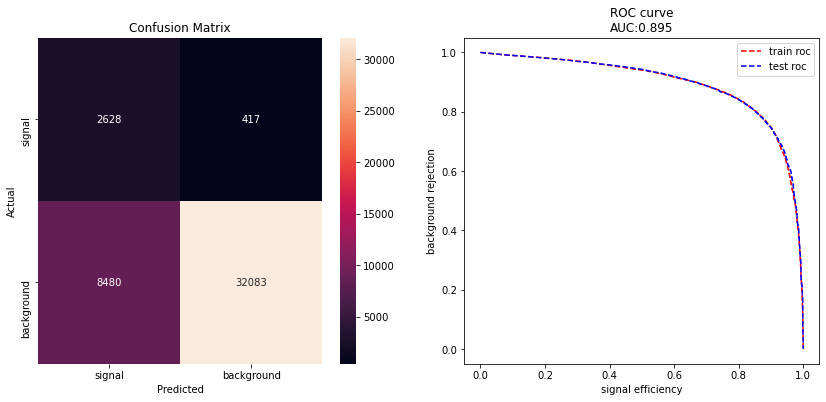

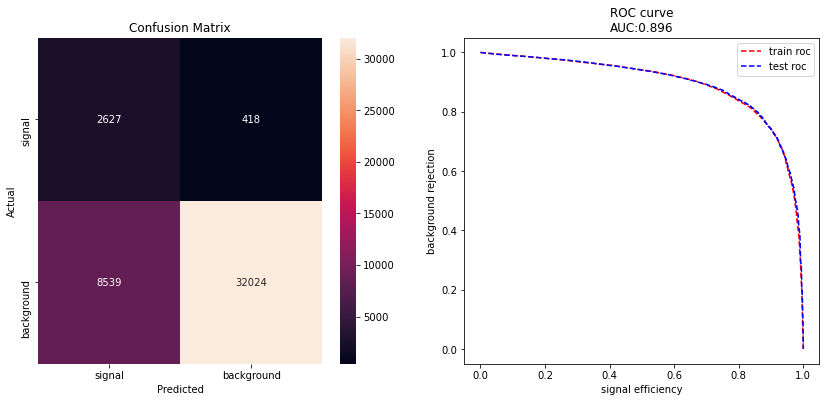

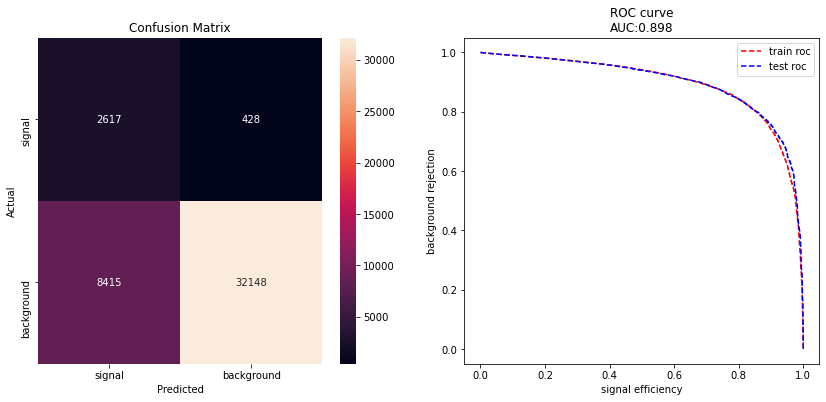

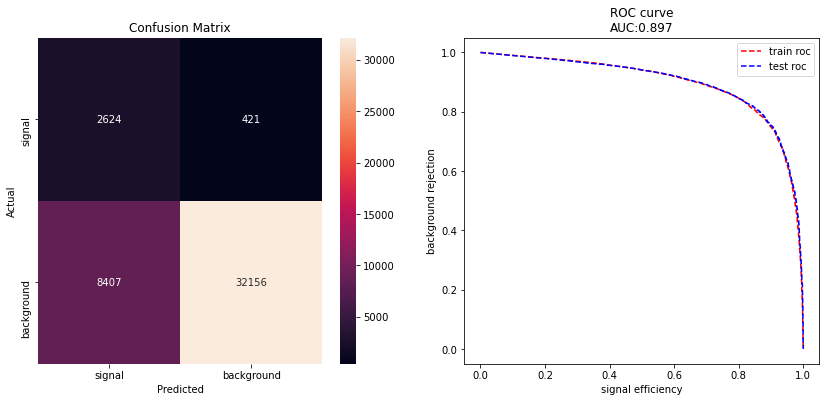

In [14]:
manager = DataManager(signal_fold, ttX_fold, features)
for idx in range(4):
    print(f"{idx} fold")
    train_loader, val_loader, test_loader = manager.get_dataloaders(idx=3)
    class_weights = manager.class_weights
    #model = SelfNormDNN(len(features), 2).to(DEVICE)
    model = SimpleDNN(len(features), 2, activation='elu').to(DEVICE)
    optimizer = optim.Adadelta(model.parameters(), lr=0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    early_stopping = EarlyStopping(patience=7, path=f"Outputs/{CHANNEL}/{MASS_POINT}/chkpoint_simplednn_elu_sig_vs_ttX_{idx}.pt")
	
    for epoch in range(EPOCHS):
        loss, acc = train(model, train_loader, optimizer, class_weights, epoch)
        scheduler.step()
        test_loss, test_acc = evaluate(model, val_loader, class_weights, epoch)
        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    X_train, X_test = manager.X_train, manager.X_test
    y_train, y_test = manager.y_train, manager.y_test

    pred_test = predict(model, X_test)
    pred_prob_train = predict(model, X_train, prob=True)
    pred_prob_test = predict(model, X_test, prob=True)
    cm = metrics.confusion_matrix(y_test, pred_test)
    fpr_train, tpr_train, thresh_train = metrics.roc_curve(y_train,
	                                                       pred_prob_train,
	                                                       pos_label=0)
    fpr, tpr, thresh = metrics.roc_curve(y_test, pred_prob_test, pos_label=0)
    auc_train = metrics.auc(fpr_train, tpr_train)
    auc = metrics.auc(fpr, tpr)
    print(auc_train, auc)
    print((auc_train-auc)/auc_train)

    plt.figure(figsize=(14, 6))
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title("Confusion Matrix")
    ax1 = sns.heatmap(cm, annot=True,
	                      fmt='d',
	                      square=False,
	                      xticklabels=['signal', 'background'],
	                      yticklabels=['signal', 'background'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title(f'ROC curve\nAUC:{round(auc, 3)}')
    ax2.plot(tpr_train, 1 - fpr_train, 'r--', label='train roc')
    ax2.plot(tpr, 1 - fpr, 'b--', label='test roc')
    ax2.legend(loc='best')
    ax2.set_xlabel('signal efficiency')
    ax2.set_ylabel('background rejection')

    plt.savefig(f"Outputs/{CHANNEL}/{MASS_POINT}/roc_simplednn_elu_sig_vs_ttX_{idx}.png")

0 fold
Assume N_FOLD = 4
[0] Train Loss: 0.63344407081604, Train Acc: 59.538009384184384
[0] Test Loss: 1.117353361967127, Test Acc: 64.643200879967

[1] Train Loss: 0.550308108329773, Train Acc: 67.58331471391988
[1] Test Loss: 1.0483425784992841, Test Acc: 69.47614464457583

[2] Train Loss: 0.5220484137535095, Train Acc: 70.83168623137342
[2] Test Loss: 1.0075788577911238, Test Acc: 71.52481781933177

[3] Train Loss: 0.5081196427345276, Train Acc: 72.61743120842858
[3] Test Loss: 0.9806338703224228, Test Acc: 73.55974150969338

[4] Train Loss: 0.49596676230430603, Train Acc: 74.45817506831892
[4] Test Loss: 0.9687707566106957, Test Acc: 74.97593840230991

[5] Train Loss: 0.4878329336643219, Train Acc: 75.82455356375574
[5] Test Loss: 0.956981759115277, Test Acc: 76.40588477932077

[6] Train Loss: 0.48157015442848206, Train Acc: 76.66156781190382
[6] Test Loss: 0.9399625656776213, Test Acc: 77.38209817131857

[7] Train Loss: 0.4755524694919586, Train Acc: 77.94372926799925
[7] Test Lo

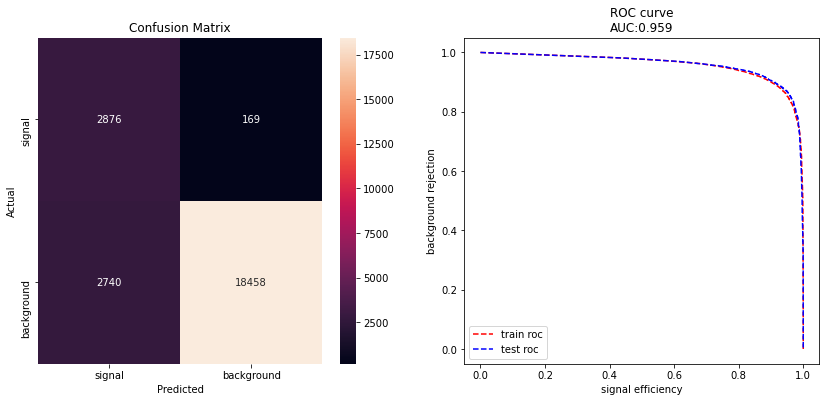

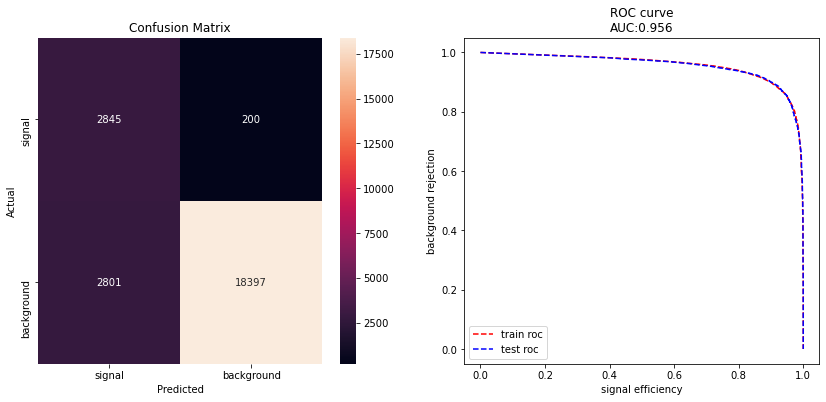

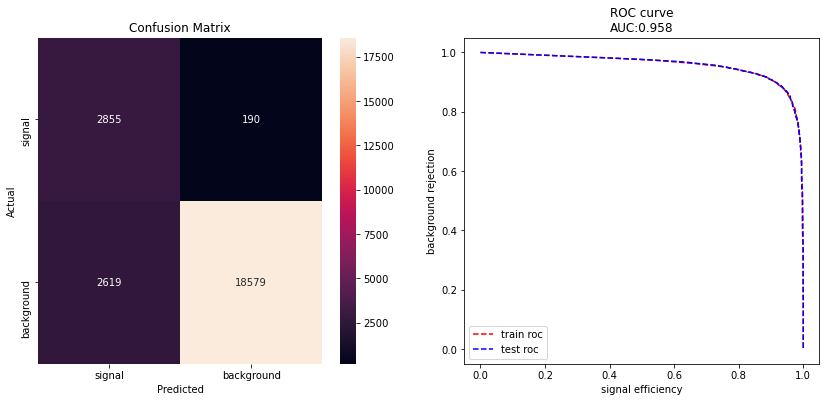

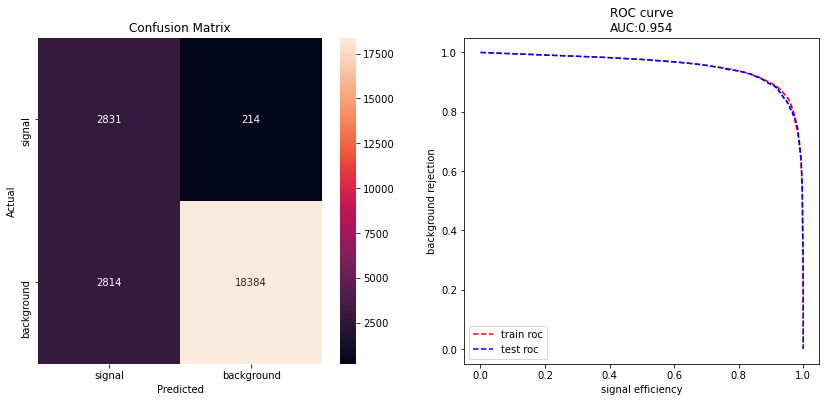

In [15]:
manager = DataManager(signal_fold, others_fold, features)
for idx in range(4):
    print(f"{idx} fold")
    train_loader, val_loader, test_loader = manager.get_dataloaders(idx=3)
    class_weights = manager.class_weights
    #model = SelfNormDNN(len(features), 2).to(DEVICE)
    model = SimpleDNN(len(features), 2, activation='elu').to(DEVICE)
    optimizer = optim.Adadelta(model.parameters(), lr=0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    early_stopping = EarlyStopping(patience=7, path=f"Outputs/{CHANNEL}/{MASS_POINT}/chkpoint_simplednn_elu_sig_vs_others_{idx}.pt")
	
    for epoch in range(EPOCHS):
        loss, acc = train(model, train_loader, optimizer, class_weights, epoch)
        scheduler.step()
        test_loss, test_acc = evaluate(model, val_loader, class_weights, epoch)
        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    X_train, X_test = manager.X_train, manager.X_test
    y_train, y_test = manager.y_train, manager.y_test

    pred_test = predict(model, X_test)
    pred_prob_train = predict(model, X_train, prob=True)
    pred_prob_test = predict(model, X_test, prob=True)
    cm = metrics.confusion_matrix(y_test, pred_test)
    fpr_train, tpr_train, thresh_train = metrics.roc_curve(y_train,
	                                                       pred_prob_train,
	                                                       pos_label=0)
    fpr, tpr, thresh = metrics.roc_curve(y_test, pred_prob_test, pos_label=0)
    auc_train = metrics.auc(fpr_train, tpr_train)
    auc = metrics.auc(fpr, tpr)
    print(auc_train, auc)
    print((auc_train-auc)/auc_train)

    plt.figure(figsize=(14, 6))
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title("Confusion Matrix")
    ax1 = sns.heatmap(cm, annot=True,
	                      fmt='d',
	                      square=False,
	                      xticklabels=['signal', 'background'],
	                      yticklabels=['signal', 'background'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title(f'ROC curve\nAUC:{round(auc, 3)}')
    ax2.plot(tpr_train, 1 - fpr_train, 'r--', label='train roc')
    ax2.plot(tpr, 1 - fpr, 'b--', label='test roc')
    ax2.legend(loc='best')
    ax2.set_xlabel('signal efficiency')
    ax2.set_ylabel('background rejection')

    plt.savefig(f"Outputs/{CHANNEL}/{MASS_POINT}/roc_simplednn_elu_sig_vs_others_{idx}.png")